In [1]:
import sys, os, time
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data, get_options

np.set_printoptions(linewidth=120)

In [2]:
media_root = '/is/ei/fleeb/workspace/media/hybrid/'
root = '../trained_nets/'
names = [n for n in os.listdir(root) if 'dspr' in n]
for i, name in enumerate(names):
    print(i,name)

0 dspr-hybrid4-dim8-beta1-fmatch_191023-193334
1 dspr-hybrid5-dim5-beta1_191022-125356
2 test-dspr-vaegan-dim8-beta1-featurematch_191022-173847
3 dspr-hybrid4-dim4-beta1-fmatch_191023-193356
4 dspr-hybrid5-dim5-beta1-fakerec_191022-160251
5 test-dspr-hybrid8-dim8-beta1-fmatch_191022-192316
6 test-dspr-hybrid5-dim5-beta1-fmatch_191023-171400
7 test-dspr-vaegan-dim8-beta1_191022-165034
8 dspr-hybrid8-dim8-beta1_191022-164934
9 test-dspr-vaegan-dim8-beta1-featurematch-vaeonly_191022-180358
10 dspr-hybrid5-dim5_191022-142333
11 test-dspr-vaegan-dim8-beta1_191022-165056
12 test-dspr-vaegan-dim8-beta1-fmatch-vaeonly-fakerec_191022-181038
13 test-dspr-vaegan-dim8-beta1-fmatch-vaeonly-fakerec_191022-192547
14 test-dspr-vaegan-dim8-beta1-fmatch-vaeonly-fakegenrec_191022-192552
15 dspr-hybrid8-dim8-beta1-fmatch_191022-192637
16 dspr-vaegan-dim8-beta1-fmatch-vaeonly-fakerec_191022-192638
17 dspr-vaegan-dim8-beta1-fmatch-vaeonly-fakegenrec_191022-192640
18 dspr-hybrid5-dim5-beta1-fmatch_191023-101

In [3]:
name = names[18]
name

'dspr-hybrid5-dim5-beta1-fmatch_191023-101632'

In [4]:
save_dir = os.path.join(media_root, name)
util.create_dir(save_dir)
args, (datasets, model) = train.load(os.path.join(root, name), load_data=get_data, load_model=get_model)
model.to(args.device)
print(model)

Loaded ../trained_nets/dspr-hybrid5-dim5-beta1-fmatch_191023-101632/best.pth.tar
Loaded model_state from checkpoint
Hybrid_Generator(
  (enc): Conv_Encoder(
    (conv): Sequential(
      (0): ConvLayer(
        (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
        (nonlin): PReLU(num_parameters=1)
      )
      (1): ConvLayer(
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=True)
        (nonlin): PReLU(num_parameters=1)
      )
      (2): ConvLayer(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

In [5]:
# # args.dataset = '3dshapes'
# args.dataset = 'dsprites'

# datasets = get_data(args)

In [6]:
def show_nums(imgs):
    B = imgs.size(0)
    l = int(np.sqrt(B))
    assert l**2 == B, 'not right: {} {}'.format(l, B)
    
    imgs = imgs.cpu().permute(0,2,3,1).squeeze().numpy()
    
    fig, axes = plt.subplots(l,l, figsize=(6,6))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(img)
        ax.axis('off')
#     fig.tight_layout()

In [7]:
trainloader, *other = train.get_loaders(*datasets, batch_size=64, num_workers=args.num_workers,
							   shuffle=True, drop_last=False, )

traindata len=737280, trainloader len=11520
Batch size: 64 samples


In [8]:
loader = iter(trainloader)

In [9]:
batch = next(loader)
batch = util.to(batch, args.device)

In [10]:
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 1, 64, 64]), torch.Size([64, 6]))

<IPython.core.display.Javascript object>


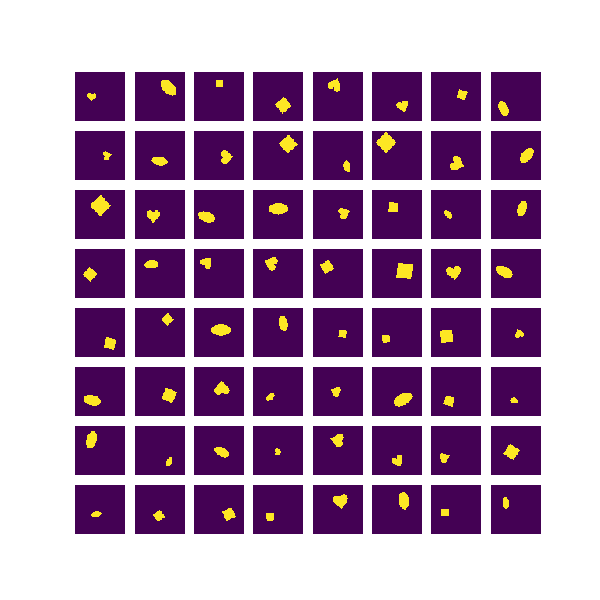

In [11]:
show_nums(X)

/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<IPython.core.display.Javascript object>


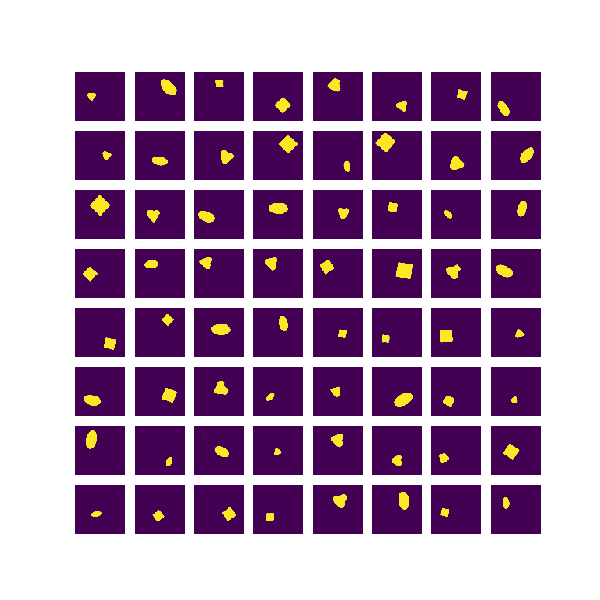

(torch.Size([64, 1, 64, 64]), torch.Size([64, 5]))

In [12]:
with torch.no_grad():
    q = model.encode(X)
    rec = model.decode(q)
show_nums(rec)
rec.shape, q.shape

In [13]:
q[0]

tensor([-1.1903,  1.5190,  0.0624,  1.8003,  0.6365], device='cuda:0')

In [14]:
q.min(0)[0], q.max(0)[0], q.mean(0), q.std(0)

(tensor([-2.7201, -3.4530, -2.6161, -3.2104, -3.3747], device='cuda:0'),
 tensor([3.2279, 2.9697, 6.3185, 3.4700, 2.6115], device='cuda:0'),
 tensor([ 0.0063, -0.0273, -0.0577,  0.1687,  0.1013], device='cuda:0'),
 tensor([1.4144, 1.2242, 1.4260, 1.3597, 1.0976], device='cuda:0'))

<IPython.core.display.Javascript object>


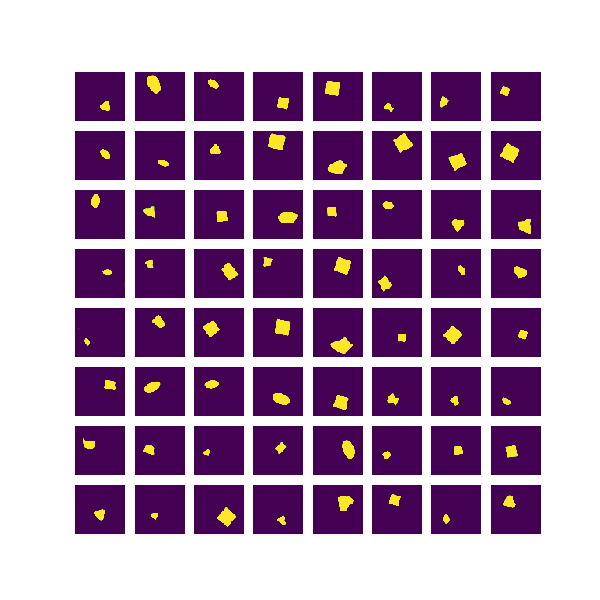

(torch.Size([64, 5]), torch.Size([64, 1, 64, 64]))

In [15]:
with torch.no_grad():
    hyb = model.hybridize(q)
    hygen = model.decode(hyb)
show_nums(hygen)
hyb.shape, hygen.shape

In [27]:
# dim = 2
# idx = 1

# plt.figure()
# plt.imshow(rec[idx,0].cpu().numpy())
# plt.axis('off')

# dev = q[:,dim].std()
# deltas = torch.linspace(q[:,dim].min()-dev, q[:,dim].max()+dev, 64)
# vecs = torch.stack([q[idx]]*64)
# vecs[:,dim] = deltas

# with torch.no_grad():
#     walks = model.decode(vecs)

# show_nums(walks)

In [17]:

with torch.no_grad():
    vrec = model.disc(rec)
vrec

tensor([[ -366.9489],
        [  592.0283],
        [  727.5854],
        [ 1044.3296],
        [ -162.8859],
        [  799.6487],
        [  211.9269],
        [ 1349.3292],
        [  421.7267],
        [  649.7476],
        [   11.3410],
        [ 1725.3241],
        [  552.4479],
        [ 1483.0206],
        [  335.9627],
        [  917.5236],
        [ -338.0988],
        [-1019.1552],
        [  366.1176],
        [  985.1994],
        [  -53.6318],
        [  423.0684],
        [-1019.7246],
        [  311.3407],
        [  546.8461],
        [  933.3440],
        [ 2050.7922],
        [  273.9186],
        [ 1671.6873],
        [  -99.2874],
        [ -463.8786],
        [  701.8369],
        [ 1173.4397],
        [ 1750.2015],
        [ 1240.2468],
        [  527.2935],
        [  214.8850],
        [   -4.1486],
        [   77.3009],
        [  169.3071],
        [ -243.7892],
        [ 1383.6866],
        [  306.4994],
        [-1015.2739],
        [ -330.2372],
        [ 

In [28]:
# plt.figure()
# # plt.imshow(rec[idx,0].cpu().numpy())
# plt.imshow(X[idx,0].cpu().numpy())
# plt.axis('off')

# vecs = torch.stack([q[idx]]*64)
# for i, dim in enumerate(dims):
#     dev = q[:,dim].std()
#     deltas = torch.linspace(q[:,dim].min()-dev, q[:,dim].max()+dev, 8)
#     deltas = torch.stack([deltas]*8)
#     if i == 1:
#         deltas = deltas.view(-1)
#     else:
#         deltas = deltas.t().contiguous().view(-1)
    
#     vecs[:,dim] = deltas

# with torch.no_grad():
#     walks = model.decode(vecs)

# show_nums(walks)

In [29]:
# plt.savefig(os.path.join(media_root,'dim5_2d_slice_3.png'))

In [35]:
dims = [0,1]
dims = [2,3]
# dims = [3,4]
idx = 0

In [36]:
H, W = 64, 64
grids = torch.from_numpy(np.mgrid[0:1:H*1j,0:1:W*1j]).to(args.device)
mn, mx = q[:,dims].min(0)[0].view(-1,1,1), q[:,dims].max(0)[0].view(-1,1,1)
grids *= mx - mn
grids += mn

deltas = grids.view(2,-1)
vecs = torch.stack([q[idx]]*deltas.size(-1))
vecs[:,dims[0]] = deltas[0]
vecs[:,dims[1]] = deltas[1]

qr = q[idx,dims]
qr = (qr - mn.squeeze()) / (mx-mn).squeeze()
qr *= torch.tensor([H,W]).to(args.device)
qr = qr.long().cpu().numpy()

<IPython.core.display.Javascript object>


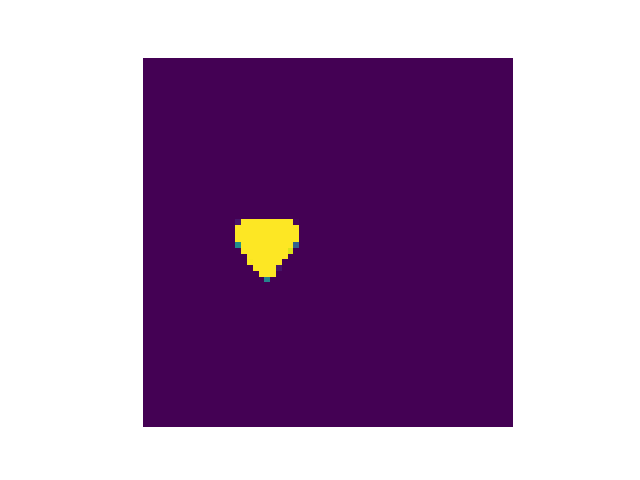

(-0.5, 63.5, 63.5, -0.5)

In [37]:
plt.figure()
plt.imshow(rec[idx,0].cpu().numpy())
plt.axis('off')

<IPython.core.display.Javascript object>


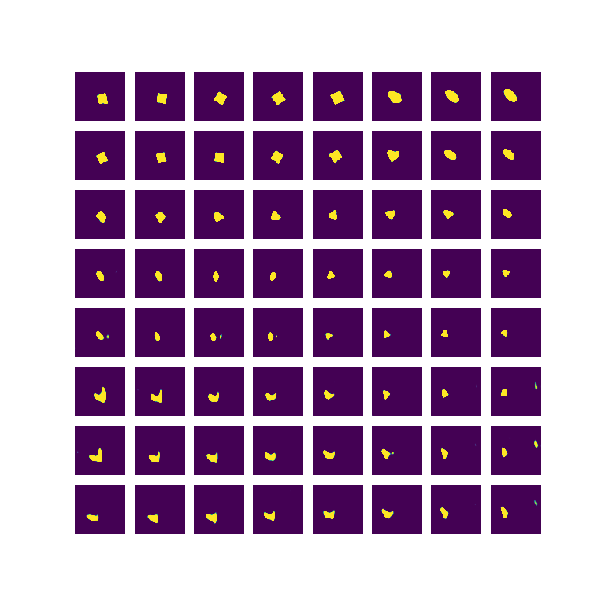

In [38]:
qimg = vecs.view(H,W,-1)[::8, ::8]
with torch.no_grad():
    imgs = model.decode(qimg)
show_nums(imgs)

In [39]:
plt.savefig(os.path.join(save_dir,'dims{}{}-idx{idx}-recs.png'.format(*dims, idx=idx)))

<IPython.core.display.Javascript object>


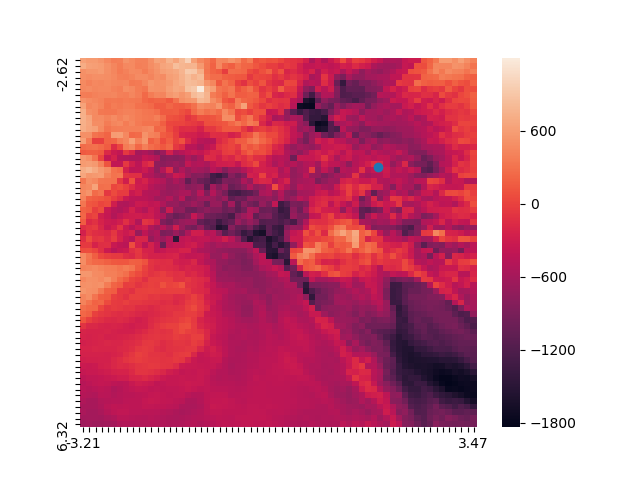

In [40]:
DL = DataLoader(TensorDataset(vecs), batch_size=128, shuffle=False)
verdicts = []
for v, in DL:
    with torch.no_grad():
        gens = model.decode(v)
        verdicts.append(model.disc(gens).detach())
verdicts = torch.cat(verdicts).view(H,W)
plt.figure()
ax = sns.heatmap(verdicts.cpu().numpy(), linewidth=0., 
                 xticklabels=['{:3.2f}'.format(mn[1].item())]+[None]*62 + ['{:3.2f}'.format(mx[1].item())],
                yticklabels=['{:3.2f}'.format(mn[0].item())]+[None]*62 + ['{:3.2f}'.format(mx[0].item())],)
# ax.set_xticks(np.linspace(mn[0].item(),mx[0].item(),H))
# ax.axis([mn[0].item(), mx[0].item(), mn[1].item(), mx[1].item()])

plt.scatter([qr[1].item()], [qr[0].item()])
plt.show()

In [26]:
plt.savefig(os.path.join(save_dir,'dims{}{}-idx{idx}-map.png'.format(*dims, idx=idx)))